In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

Importing dataset present in dataset folder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/My Colab Dataset/startup_funding.csv')

High level overview of the data we are dealing with

In [4]:
data.head()

,SNo,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Remarks
0,0,01/08/2017,TouchKin,Technology,Predictive Care Platform,Bangalore,Kae Capital,Private Equity,"1,300,000",NaN
1,1,02/08/2017,Ethinos,Technology,Digital Marketing Agency,Mumbai,Triton Investment Advisors,Private Equity,NaN,NaN
2,2,02/08/2017,Leverage Edu,Consumer Internet,Online platform for Higher Education Services,New Delhi,"Kashyap Deorah, Anand Sankeshwar, Deepak Jain,...",Seed Funding,NaN,NaN
3,3,02/08/2017,Zepo,Consumer Internet,DIY Ecommerce platform,Mumbai,"Kunal Shah, LetsVenture, Anupam Mittal, Hetal ...",Seed Funding,"500,000",NaN
4,4,02/08/2017,Click2Clinic,Consumer Internet,healthcare service aggregator,Hyderabad,"Narottam Thudi, Shireesh Palle",Seed Funding,"850,000",NaN


In [5]:
data.tail()

,SNo,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Remarks
2367,2367,29/01/2015,Printvenue,NaN,NaN,NaN,Asia Pacific Internet Group,Private Equity,"4,500,000",NaN
2368,2368,29/01/2015,Graphene,NaN,NaN,NaN,KARSEMVEN Fund,Private Equity,"825,000",Govt backed VC Fund
2369,2369,30/01/2015,Mad Street Den,NaN,NaN,NaN,"Exfinity Fund, GrowX Ventures.",Private Equity,"1,500,000",NaN
2370,2370,30/01/2015,Simplotel,NaN,NaN,NaN,MakeMyTrip,Private Equity,NaN,"Strategic Funding, Minority stake"
2371,2371,31/01/2015,couponmachine.in,NaN,NaN,NaN,UK based Group of Angel Investors,Seed Funding,"140,000",NaN


In [6]:
print('data contains',data.shape[0],'rows and',data.shape[1],'columns',sep=' ')

data contains 2372 rows and 10 columns


**Lets see the columns (features) we have available.**

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SNo               2372 non-null   int64 
 1   Date              2372 non-null   object
 2   StartupName       2372 non-null   object
 3   IndustryVertical  2201 non-null   object
 4   SubVertical       1436 non-null   object
 5   CityLocation      2193 non-null   object
 6   InvestorsName     2364 non-null   object
 7   InvestmentType    2371 non-null   object
 8   AmountInUSD       1525 non-null   object
 9   Remarks           419 non-null    object
dtypes: int64(1), object(9)
memory usage: 185.4+ KB
None


In [8]:
null_values=pd.isnull(data).sum()
columns=null_values.index
frequency=null_values.values
percentage=(frequency/data.shape[0])*100
missing_values=pd.DataFrame({'Columns':columns,'Missing Data':frequency,'Percentage':percentage}).sort_values('Percentage',ascending=False).set_index('Columns')
missing_values

,Missing Data,Percentage
Columns,,
Remarks,1953,82.335582
SubVertical,936,39.460371
AmountInUSD,847,35.708263
CityLocation,179,7.546374
IndustryVertical,171,7.209106
InvestorsName,8,0.337268
InvestmentType,1,0.042159
SNo,0,0.000000
Date,0,0.000000


In [9]:
data.drop(columns=['Remarks'],inplace=True)
data.drop(columns=['SNo'],inplace=True)

In [10]:
null_values=pd.isnull(data).sum()
columns=null_values.index
frequency=null_values.values
percentage=(frequency/data.shape[0])*100
missing_values=pd.DataFrame({'Columns':columns,'Missing Data':frequency,'Percentage':percentage}).sort_values('Percentage',ascending=False).set_index('Columns')
missing_values

,Missing Data,Percentage
Columns,,
SubVertical,936,39.460371
AmountInUSD,847,35.708263
CityLocation,179,7.546374
IndustryVertical,171,7.209106
InvestorsName,8,0.337268
InvestmentType,1,0.042159
Date,0,0.000000
StartupName,0,0.000000


Now, lets go one by one and try to fill out missing values in each column.

# **SubVertical**

In [11]:
data['SubVertical'].describe()

count                1436
unique               1364
top       Online Pharmacy
freq                    9
Name: SubVertical, dtype: object

In [12]:
len(data['SubVertical'].unique())

1365

There are 1365 unique sub-categories and 936 unknown sub-categories

We have two options from here, that is,
1.   Fill up the missing values as 'Not specified' string
2.   Do not fill up the missing values.

For this analysis, we intend to not fill up the missing values for the SubVertical columns since later on, it might affect our analysis.

In [13]:
data['SubVertical'].fillna(value='Not Specified or Other',inplace=True)

# **AmountInUSD**

In [14]:
data['AmountInUSD'].head()

0    1,300,000
1          NaN
2          NaN
3      500,000
4      850,000
Name: AmountInUSD, dtype: object

We see that the column is not in numeric format, so lets correct the format and then try to fill up the missing values

In [15]:
data['AmountInUSD']=data['AmountInUSD'].apply(lambda x: float(str(x).replace(',','')))

In [16]:
import math
data['AmountInUSD'].describe().apply(lambda x: math.ceil(x))
# applied math.ceil() to express the numbers in normal format instead of exponential

count          1525
mean       12031074
std        64031176
min           16000
25%          370000
50%         1070000
75%         6000000
max      1400000000
Name: AmountInUSD, dtype: int64

In [17]:
data[data['AmountInUSD'].isnull()].shape

(847, 8)

# **CityLocation**

The missing value for cities can be filled by 'Not Specified"

In [18]:
data['CityLocation'].head(10)

0    Bangalore
1       Mumbai
2    New Delhi
3       Mumbai
4    Hyderabad
5    Bangalore
6    Ahmedabad
7      Gurgaon
8    Bangalore
9        Noida
Name: CityLocation, dtype: object

In [19]:
data['CityLocation'].describe()

count          2193
unique           71
top       Bangalore
freq            627
Name: CityLocation, dtype: object

In [20]:
data[data['CityLocation'].isnull()].shape

(179, 8)

There are 179 null values in CityLocation. that is 7% of the entire data set. Let's fill up the null values with "Not Specific".
Also, if we see closely, some rows have multiple cities, So lets clean them up and just use one city name.

In [21]:
data['CityLocation'].fillna(value='Not Specified',inplace=True)

Making a function to check if multiple cities are mentioned separated by '/', if yes, then replace it with the first name.

In [22]:
def city_cleaner(x):
    return x.split('/')[0].strip()

In [23]:
data['CityLocation']=data['CityLocation'].apply(city_cleaner)

In [24]:
data['CityLocation'].value_counts().head(15)

Bangalore        634
Mumbai           449
New Delhi        385
Gurgaon          241
Not Specified    179
Pune              91
Noida             79
Hyderabad         77
Chennai           67
Ahmedabad         35
Jaipur            25
Kolkata           19
Chandigarh        10
Vadodara           9
Indore             9
Name: CityLocation, dtype: int64

# **IndustryVertical**

IndustryVertical has 171 null values, filling those rows with value 'Other'.
Also, IndustryVertical consists of some duplicate values with different caps. To sort this, lets convert all to lowercase so that all have same caps

In [25]:
data['IndustryVertical'].head(10)

0           Technology
1           Technology
2    Consumer Internet
3    Consumer Internet
4    Consumer Internet
5    Consumer Internet
6           Technology
7            eCommerce
8            eCommerce
9            eCommerce
Name: IndustryVertical, dtype: object

In [26]:
data['IndustryVertical'].fillna('Others',inplace=True)

In [27]:
data['IndustryVertical']=data['IndustryVertical'].apply(lambda x: x.lower())


# **InvestorsName**

In [28]:
data['InvestorsName'].value_counts().head()

Undisclosed Investors    33
Undisclosed investors    27
Ratan Tata               24
Indian Angel Network     24
Kalaari Capital          16
Name: InvestorsName, dtype: int64

InvestorsName has 8 null values, filling those rows with value 'Undisclosed Investors'.
Also we need to change 'Undisclosed investors' to 'Undisclosed Investors'

In [29]:
data['InvestorsName'].fillna(value='Undisclosed Investors',inplace=True)
data['InvestorsName']=data['InvestorsName'].replace('Undisclosed investors','Undisclosed Investors')

In [30]:
data['InvestorsName'].value_counts().head()

Undisclosed Investors       68
Indian Angel Network        24
Ratan Tata                  24
Kalaari Capital             16
Group of Angel Investors    15
Name: InvestorsName, dtype: int64


# **InvestmentType**

In [31]:
data['InvestmentType'].describe()

count             2371
unique               7
top       Seed Funding
freq              1271
Name: InvestmentType, dtype: object

Let's fill up the 1 missing value in InvestmentType with the most common value, that is, Seed Funding

In [32]:
data['InvestmentType'].fillna('Seed Funding',inplace=True)


# **Date**

In [33]:
data['Date'].describe()

count           2372
unique           701
top       30/11/2016
freq              11
Name: Date, dtype: object

When we initially tried to convert Date column to date time, several errors popped up due to bad format ('.' instead of '/' and so on. So cleaned the strings, then converted to datetime

In [34]:
data['Date']=data['Date'].apply(lambda x: str(x).replace('.','/'))
data['Date']=data['Date'].apply(lambda x: str(x).replace('//','/'))

In [35]:
data['Date']=pd.to_datetime(data['Date'])

In [36]:
data.head()

,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD
0,2017-01-08,TouchKin,technology,Predictive Care Platform,Bangalore,Kae Capital,Private Equity,1300000.0
1,2017-02-08,Ethinos,technology,Digital Marketing Agency,Mumbai,Triton Investment Advisors,Private Equity,NaN
2,2017-02-08,Leverage Edu,consumer internet,Online platform for Higher Education Services,New Delhi,"Kashyap Deorah, Anand Sankeshwar, Deepak Jain,...",Seed Funding,NaN
3,2017-02-08,Zepo,consumer internet,DIY Ecommerce platform,Mumbai,"Kunal Shah, LetsVenture, Anupam Mittal, Hetal ...",Seed Funding,500000.0
4,2017-02-08,Click2Clinic,consumer internet,healthcare service aggregator,Hyderabad,"Narottam Thudi, Shireesh Palle",Seed Funding,850000.0


In [37]:
data=data.sort_values('Date',ascending=False).reset_index()

In [38]:
data.head()

,index,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD
0,19,2017-12-07,Innoviti,technology,Digital payments solutions,Bangalore,"SBI-FMO Fund, Bessemer Venture Partners, Catam...",Private Equity,18500000.0
1,22,2017-12-07,Arcatron,technology,Next Gen Mobility device manufacturer,Pune,Indian Angel Network,Seed Funding,NaN
2,21,2017-12-07,Bottr.me,technology,Chatbot creation tool,Bangalore,"500 Startups, Purvi Capital, Rajan Anandan, Ab...",Seed Funding,NaN
3,20,2017-12-07,VDeliver,logistics,Door Step Delivery platform,Hyderabad,"Corvus Ventures, MAPE Advisory Group",Private Equity,NaN
4,72,2017-12-06,CoverFox,consumer internet,Online insurance brokerage platform,Mumbai,Transamerica,Private Equity,15000000.0



# **StartupName**

In [39]:
data['StartupName']=data['StartupName'].apply(lambda x: x.lower())

While exploring the data, it was found that there have been separate names for same startups due to difference in spellings. So let's remove all ambiguous names.

In [40]:
data['StartupName']=data['StartupName'].apply(lambda x: str(x).replace('ola cabs','ola'))
data['StartupName']=data['StartupName'].apply(lambda x: str(x).replace('olacabs','ola'))
data['StartupName']=data['StartupName'].apply(lambda x: str(x).replace('flipkart.com','flipkart'))
data['StartupName']=data['StartupName'].apply(lambda x: str(x).replace('paytm marketplace','paytm'))

In [41]:
print('Number of unique startups funded:',data['StartupName'].nunique())

Number of unique startups funded: 1917


# **Exploring the Data**

In [42]:
# This method allows us to make the ticks showed in x-axis more readable by inserting newlines, We can pass in
# a series and it returns a formatted index series
def ticks_display_cleaner(series):
    putSpace=True
    index=list(series.index)
    values=list(series.values)
    for i in range(len(index)):
        c=index[i].strip().split(' ')
        if len(c)>2:
            c.insert(2,'\n')
        if len(c)>5:
            c.insert(5,'\n')
        for j in range(len(c)):
            if c[j]!='\n':
                c[j]=c[j]+' '
        index[i]=''.join(c)
    return pd.Series(values,index=index)

# **Q1. Top 20 Startups on the basis of funds acquired**

In [43]:
top_20_startups=pd.DataFrame(data.groupby('StartupName')['AmountInUSD'].sum().sort_values(ascending=False).reset_index().head(20))
top_20_startups['AmountInUSD']=top_20_startups['AmountInUSD'].apply(lambda x: math.ceil(x))
top_20_startups

,StartupName,AmountInUSD
0,paytm,2340000000
1,flipkart,2259700000
2,ola,1899500000
3,snapdeal,700000000
4,oyo rooms,375000000
5,quikr,230000000
6,delhivery,215000000
7,foodpanda,210000000
8,shopclues,207700000
9,bigbasket,207000000


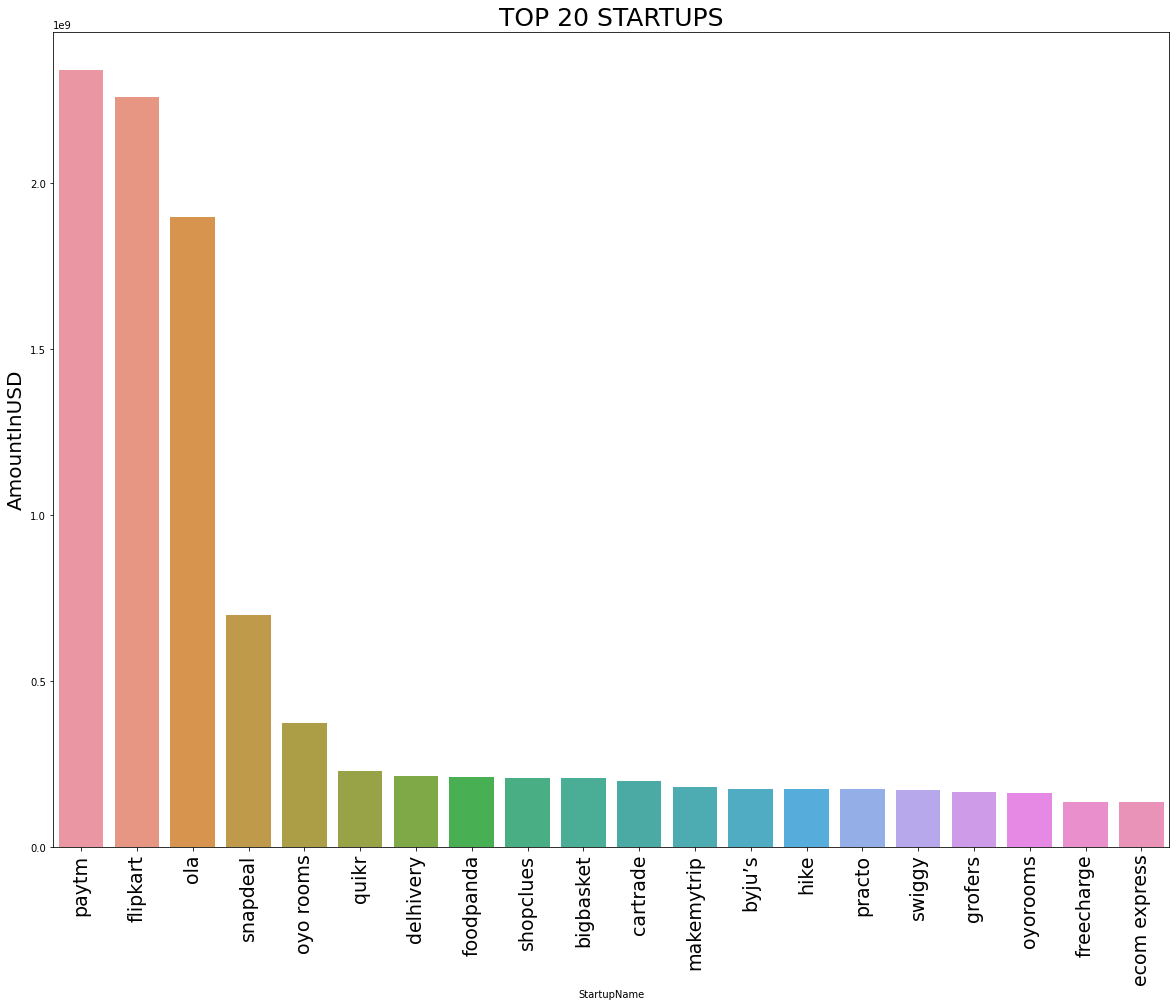

In [44]:
plt.figure(figsize=(20,15))
plt.title('TOP 20 STARTUPS',fontsize=25)
plt.xticks(fontsize=19,rotation='vertical')
plt.ylabel('Amount In USD',fontsize=20)
sns.barplot(x='StartupName',y='AmountInUSD',data=top_20_startups)
plt.savefig('top20startups.png',dpi=300)
plt.show()

The above Output shows the top 20 startups funded between January 2015 to December 2017.
Paytm and Flipkart are the highest funded startups.

# **Q2. Startup(s) which acquired the minimum amount of funds**

In [45]:
print('Minimum funds acquired by a startup: ',data['AmountInUSD'].describe()['min'])

Minimum funds acquired by a startup:  16000.0


In [46]:
data[data['AmountInUSD']==16000]

,index,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD
2322,2347,2015-01-19,yo grad,others,Not Specified or Other,Not Specified,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
2325,2345,2015-01-19,hostel dunia,others,Not Specified or Other,Not Specified,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
2326,2346,2015-01-19,play your sport,others,Not Specified or Other,Not Specified,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
2328,2348,2015-01-19,enabli,others,Not Specified or Other,Not Specified,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
2329,2349,2015-01-19,cbs,others,Not Specified or Other,Not Specified,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0


**Yo Grad, Hostel Dunia, Plan Your Sport, Enabli**, and **CBS** are the startups who acquired least funding, that is, \$16000

# **Q3. Which Industry has maximum number of startups?**

In [47]:
df=data[data['IndustryVertical']!='others']
top_10_industries=df['IndustryVertical'].value_counts().sort_values(ascending=False).head(10)
print(top_10_industries)
top_10_industries=ticks_display_cleaner(top_10_industries)

consumer internet            772
technology                   313
ecommerce                    230
healthcare                    31
logistics                     24
education                     20
food & beverage               19
finance                        9
online food delivery           5
online education platform      5
Name: IndustryVertical, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


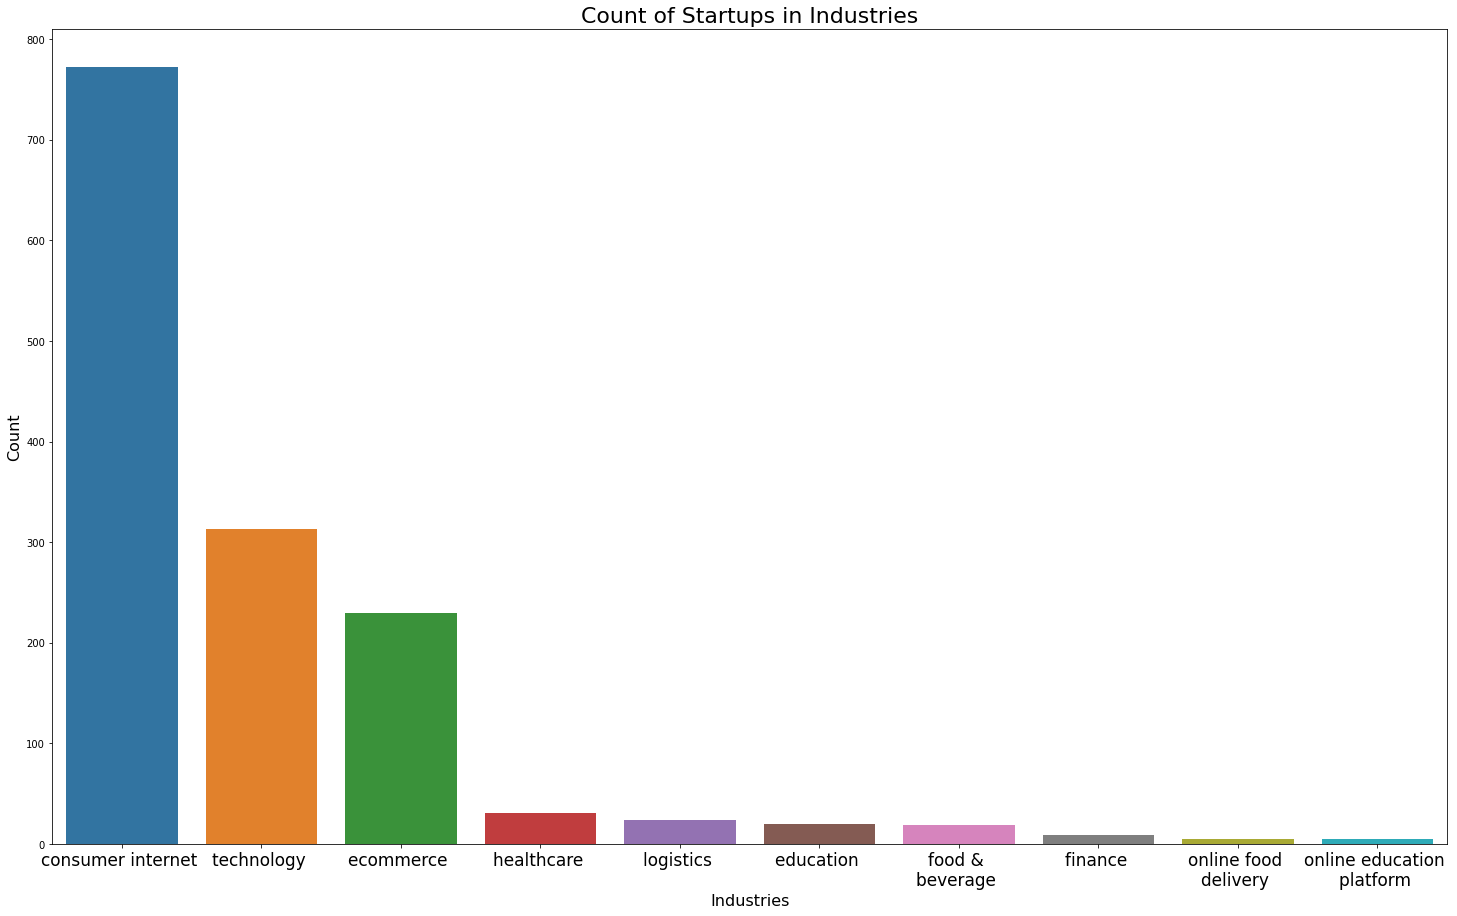

In [48]:
plt.figure(figsize=(25,15))
plt.xlabel('Industries',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.title('Count of Startups in Industries',fontsize=22)
plt.xticks(fontsize=17)
sns.barplot(top_10_industries.index,top_10_industries.values)
plt.savefig('Industries.png',dpi=300)

The top 3 industries having max number of startups are:

Consumer Internet
Technology
ECommerce

In [49]:
df=data[data['SubVertical']!='Not Specified or Other']
df['SubVertical'].value_counts(ascending=False).head(10)

Online Pharmacy                  9
Food Delivery Platform           8
Online lending platform          5
Online Learning Platform         4
Online Payment Gateway           3
ECommerce Marketplace            3
Data Analytics platform          3
Fitness Mobile App               3
Online Food Delivery Platform    2
Online Education Portal          2
Name: SubVertical, dtype: int64

# **Lets have a look at each industry from a closer point of view**
**1. Consumer Internet**

Checking out top 10 sub-categories of industry having highest number of startups

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


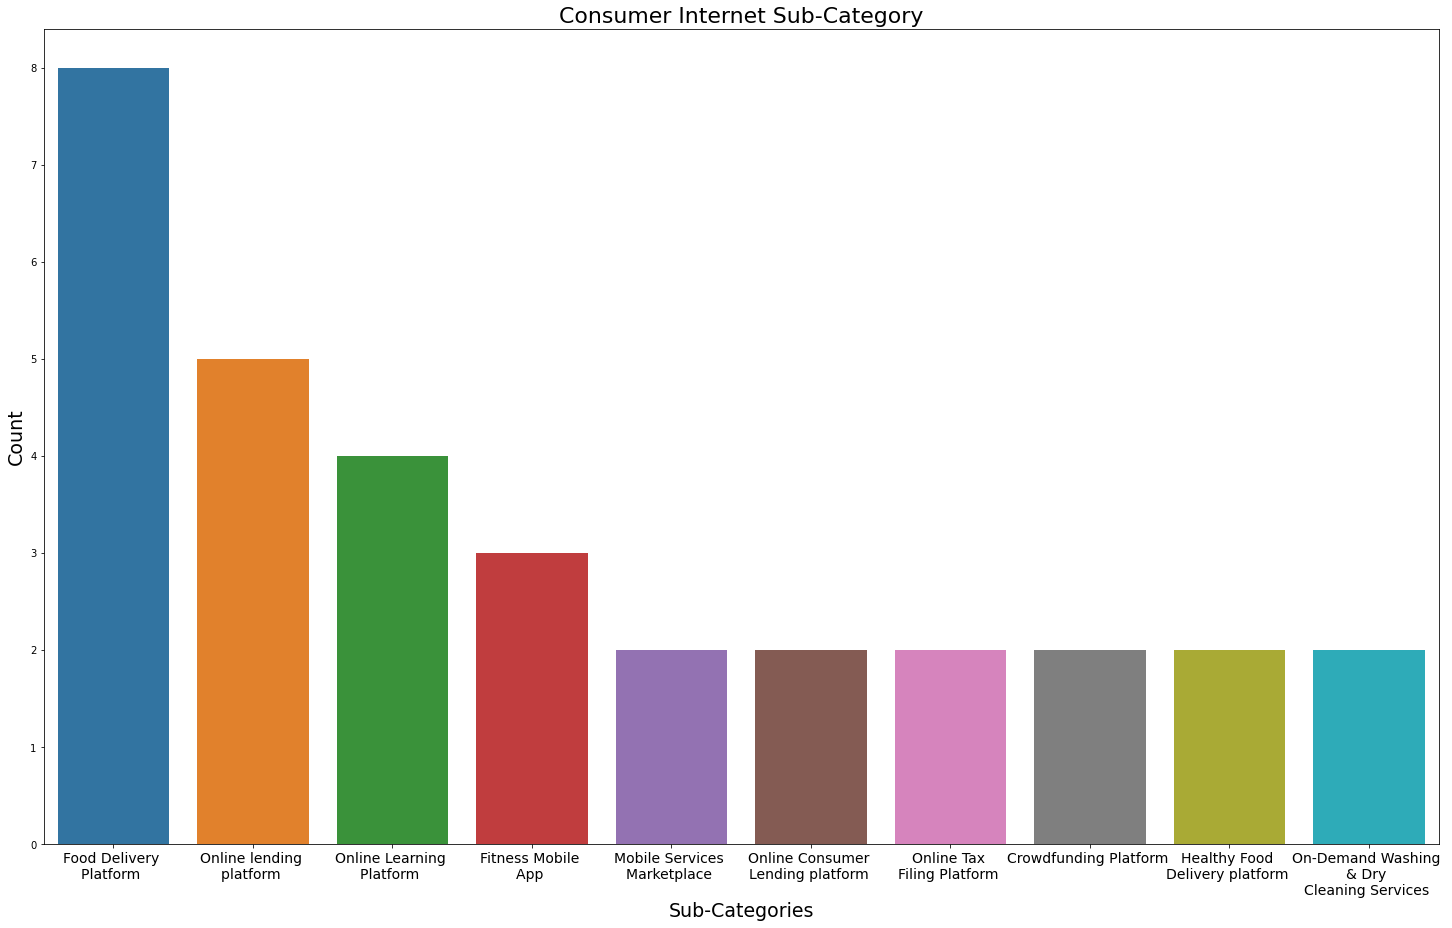

In [50]:
ci=data[data['IndustryVertical']=='consumer internet']
top_10_ci_sub=ci['SubVertical'].value_counts().sort_values(ascending=False).head(10)
top_10_ci_sub=ticks_display_cleaner(top_10_ci_sub)
plt.figure(figsize=(25,15))
plt.xticks(fontsize=14)
plt.title('Consumer Internet Sub-Category',fontsize=22)
plt.xlabel('Sub-Categories',fontsize=19)
plt.ylabel('Count',fontsize=19)
sns.barplot(top_10_ci_sub.index,top_10_ci_sub.values)
plt.savefig('Consumer-Internet.png',dpi=300)

**Food Delivery Platform** has 8 startups, followed by **Online Lending Platform, Online Learning Platform, and Fitness Mobile App** having 5,4, and 3 startups listed respectively

**Top consumer internet startups**

In [51]:
ci.groupby('StartupName')['AmountInUSD'].sum().sort_values(ascending=False).astype(int).head(10).reset_index()

,StartupName,AmountInUSD
0,ola,744500000
1,oyo rooms,250000000
2,cartrade,200000000
3,makemytrip,180000000
4,hike,175000000
5,swiggy,137000000
6,byju’s,125000000
7,oyo,100000000
8,mobikwik,90000000
9,bookmyshow,82000000


**2. Technology**

In [52]:
tech=data[data['IndustryVertical']=='technology']

**Top Technology based startups on the basis of funds acquired**

In [53]:
tech.groupby('StartupName')['AmountInUSD'].sum().sort_values(ascending=False).astype(int).head(10).reset_index()

,StartupName,AmountInUSD
0,delhivery,100000000
1,fractal analytics,100000000
2,rivigo,75000000
3,markets and markets,56000000
4,druva,51000000
5,icertis,40000000
6,eps,35000000
7,amagi media labs,35000000
8,mswipe,31000000
9,qubole,30000000


**Delhivery, Fractal Analytics, Rivigo** are top Technology based startups

# **3. ECommerce**

In [54]:
commerce=data[data['IndustryVertical']=='ecommerce']

**Top ECommerce based startups on the basis of funds acquired**

In [55]:
commerce.groupby('StartupName')['AmountInUSD'].sum().sort_values(ascending=False).astype(int).head(10).reset_index()

,StartupName,AmountInUSD
0,paytm,1660000000
1,flipkart,1509700000
2,snapdeal,200000000
3,bigbasket,157000000
4,shopclues,107700000
5,lenskart,63500000
6,pepperfry,31300000
7,1mg,30000000
8,bluestone,30000000
9,voonik,29000000


**Paytm, Flipkart, SnapDeal** are top ECommerce based startups with highest amount funded

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


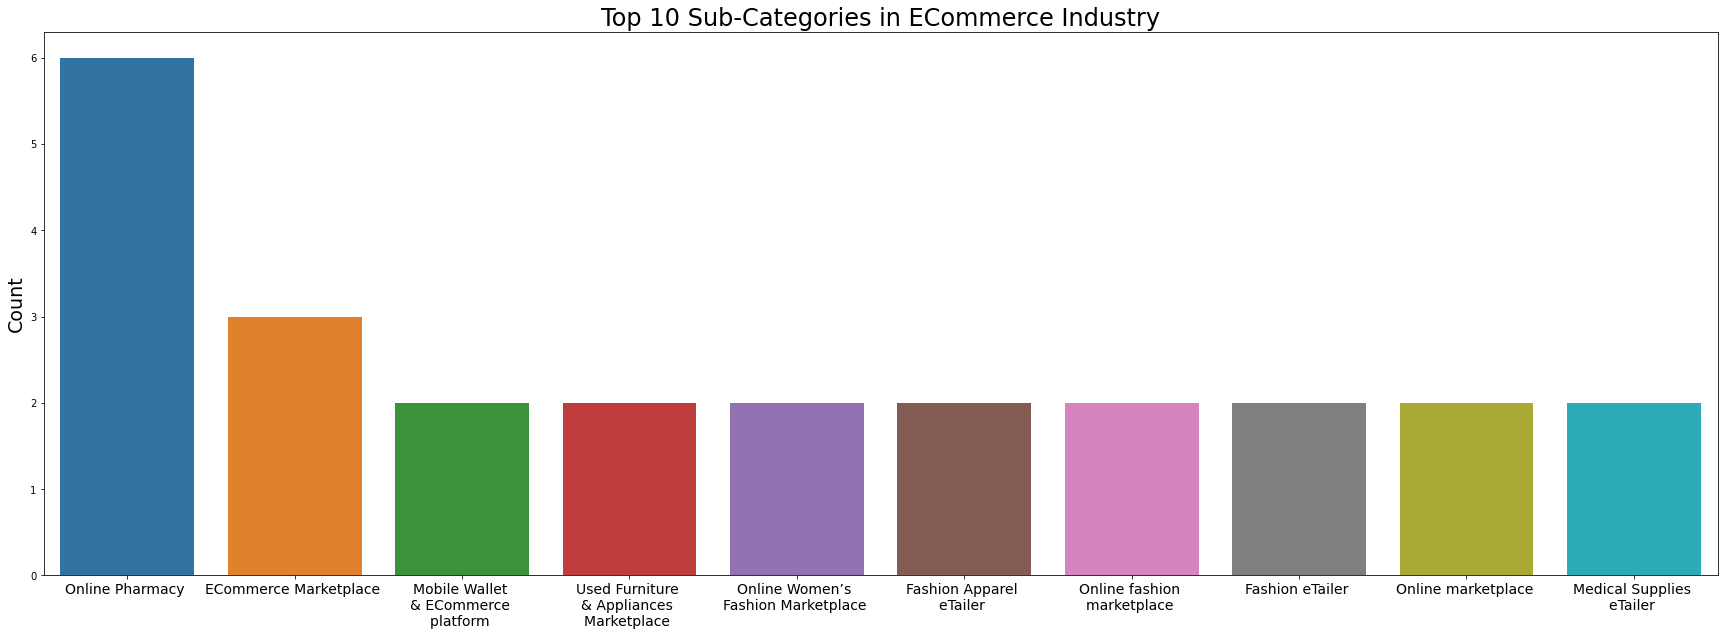

In [56]:
top_10_comm_sub=commerce['SubVertical'].value_counts().sort_values(ascending=False).head(10)
top_10_comm_sub=ticks_display_cleaner(top_10_comm_sub)
plt.figure(figsize=(30,10))
plt.ylabel('Count',fontsize=19)
plt.xticks(fontsize=14)
plt.title('Top 10 Sub-Categories in ECommerce Industry',fontsize=24)
sns.barplot(top_10_comm_sub.index,top_10_comm_sub.values)
plt.savefig('Ecommerce.png',dpi=300)

There are 6 startups based on Online Pharmacy sub-category, followed by 3 startups in **ECommerce Marketplace** Sub-Category.

# **Q4. Which period had the most number of startups funded.**

In [57]:
# Creating new columns, Month, Year, Quarter, QuarterYear
# QuarterYear is the concatenation of year+quarter to show the 4 quarters of each year which will be further used
# below in our analysis.
date_year=data['Date'].dt

data['Month']=date_year.month
data['Year']=date_year.year

data['Quarter']=''
data['Year']=data['Year'].astype('object')

data.loc[(data['Month']>=1) & (data['Month']<=3),'Quarter']=str(1)
data.loc[(data['Month']>=4) & (data['Month']<=6),'Quarter']=str(2)
data.loc[(data['Month']>=7) & (data['Month']<=9),'Quarter']=str(3)
data.loc[(data['Month']>=10) & (data['Month']<=12),'Quarter']=str(4)

data['QuarterYear']=data['Year'].astype(str)+"-Q"+data['Quarter'].astype(str)

In [58]:
data.groupby('QuarterYear')['StartupName'].count().sort_values(ascending=False)

QuarterYear
2015-Q3    275
2016-Q2    265
2016-Q1    251
2016-Q3    239
2016-Q4    238
2015-Q4    237
2015-Q2    215
2015-Q1    209
2017-Q1    166
2017-Q2    151
2017-Q3     74
2017-Q4     52
Name: StartupName, dtype: int64

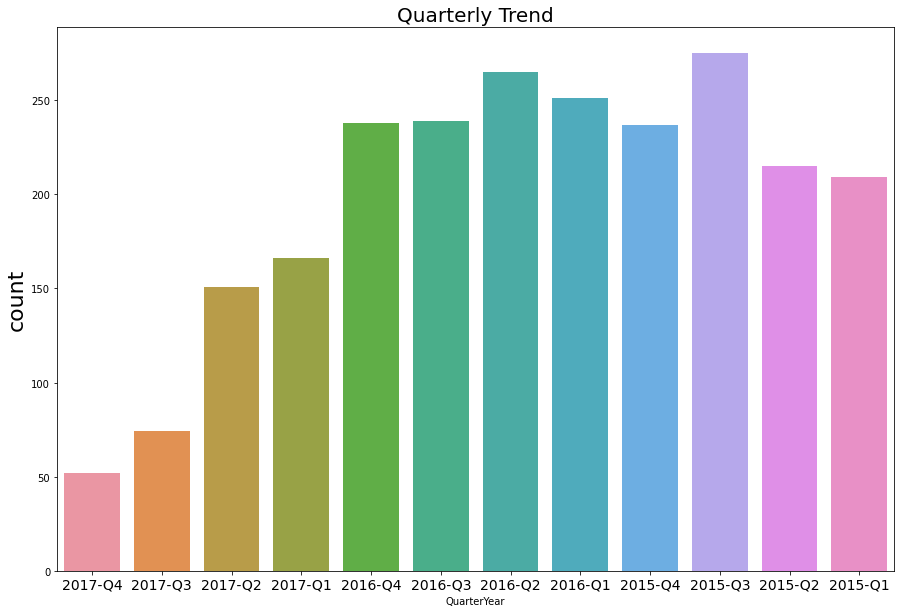

In [59]:
plt.figure(figsize=(15,10))
plt.title('Quarterly Trend',fontsize=20)
plt.ylabel('Count',fontsize=22)
plt.xticks(fontsize=14)
sns.countplot(x='QuarterYear',data=data)
plt.savefig('QuarterlyTrend.png',dpi=300)

Now, we can see that 2015, and 2016 saw most number of startups being funded. highest being in Quarter 3 of 2015. Then it started declining in 2017 Q1 to 166 startups and 2017 Q4 down to only 52 startups being funded

# **Q5. which City has maximum startups?**

In [60]:
cities=data[data['CityLocation']!='Not Specified']
cities=cities['CityLocation'].value_counts().sort_values(ascending=False).head(10)
cities

Bangalore    634
Mumbai       449
New Delhi    385
Gurgaon      241
Pune          91
Noida         79
Hyderabad     77
Chennai       67
Ahmedabad     35
Jaipur        25
Name: CityLocation, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


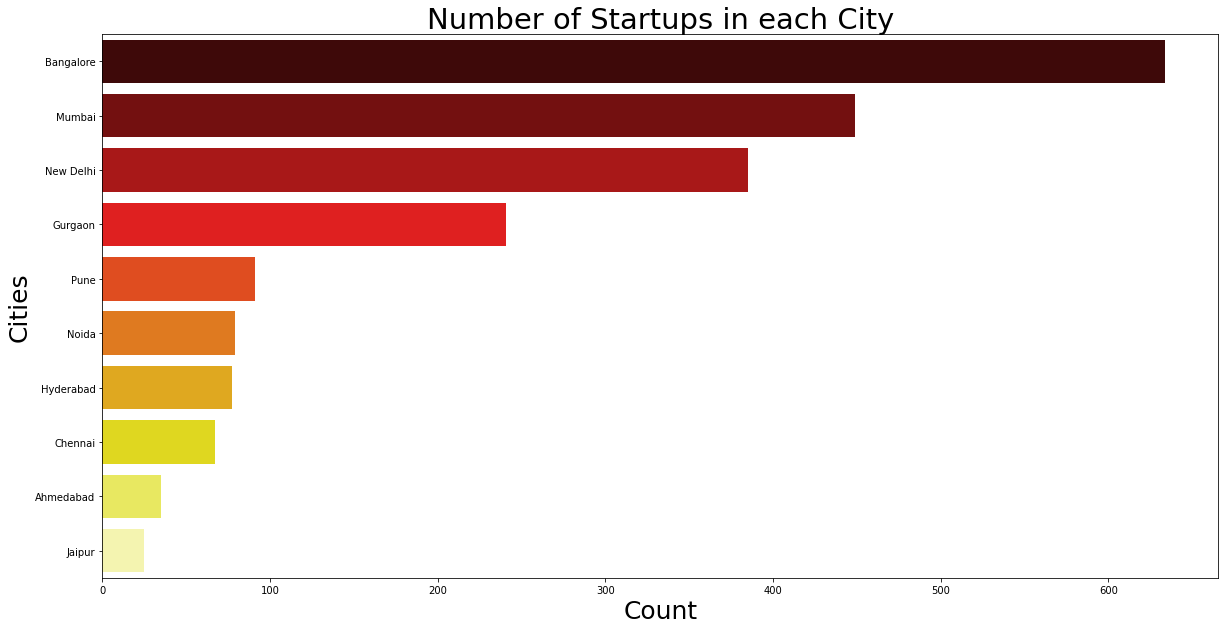

In [61]:
plt.figure(figsize=(20,10))
plt.title('Number of Startups in each City',fontsize=29)
plt.ylabel('Cities',fontsize=25)
plt.xlabel('Count',fontsize=25)
sns.barplot(cities.values,cities.index,palette='hot')
plt.show()

As we see from the graph above, maximum number of startups are based in Banglore (26.72%), followed by Mumbai (18.9%), New Delhi (16.2%), and Gurgaon (10.16%)

72% of the startups funded between January 2015 till December 2017 are based in the above mentioned four cities.

# **Q6. Who are the Top Investors by number of startups funded.**

In [62]:
data['InvestorsName'].describe()

count                      2372
unique                     1884
top       Undisclosed Investors
freq                         68
Name: InvestorsName, dtype: object

In [63]:
data['InvestorsName'].values[0]

'SBI-FMO Fund, Bessemer Venture Partners, Catamaran Ventures'

There are several spelling for undisclosed investors, so let's clean that up.

In [64]:
def investors_cleaner(x):
    b=str(x).lower()
    if 'undisclosed' in b:
        return 'Undisclosed Investor'
    else:
        return x

In [65]:
data['InvestorsName']=data['InvestorsName'].apply(investors_cleaner)

We see that a startup can be funded by multiple investors separated by commas. So let's make a new column 'NumberOfInvestors' which counts the number of investors for a particular startup

In [66]:
def investors_counter(x):
    l=x.split(',')
    return len(l)

In [67]:
data['NumberOfInvestors']=data['InvestorsName'].apply(investors_counter)

To find out the Investor who has funded maximum number of companies, we need to devise a way because some companies have multiple investors and we need to search each row for occurence of each investors name and count it. We will use re.search() method for this task. Below is the devised algorithm to find out actual number of startups funded by each investor by analysing rows with multiple investor names

**Note:** I do not take into account that startups have got multiple fundings at different point of times, i am just counting number of startups that were funded by each investor once, or more than once.

In [68]:
investors_companies_funded={}
unique_name=data['InvestorsName'].unique()
name=np.array(data['InvestorsName'].values)
for i in range(len(unique_name)):
    for j in range(len(name)):
        if(re.search(unique_name[i],name[j])):
            investors_companies_funded[unique_name[i]]=investors_companies_funded.get(unique_name[i],0)+1

In [69]:
lst_investors = pd.DataFrame({'Name':list(investors_companies_funded.keys()),'Number of Startups Funded':list(investors_companies_funded.values())}).sort_values('Number of Startups Funded',ascending=False)

In [70]:
lst_investors[lst_investors['Name']!='Undisclosed Investor'].head(10)

,Name,Number of Startups Funded
137,Sequoia Capital,74
117,Accel Partners,63
447,Kalaari Capital,51
159,Blume Ventures,47
460,SAIF Partners,45
1,Indian Angel Network,42
898,Tiger Global,41
1372,IDG Ventures,40
563,Ratan Tata,30
1596,Mohandas Pai,29


The below code allows us to find the startups funded by each investor by passing in investor name as parameter. (Note: Some startups have more than one investors)

In [71]:
temp=investors_companies_funded
del temp['Undisclosed Investor']
index=list(temp.keys())
values=list(temp.values())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


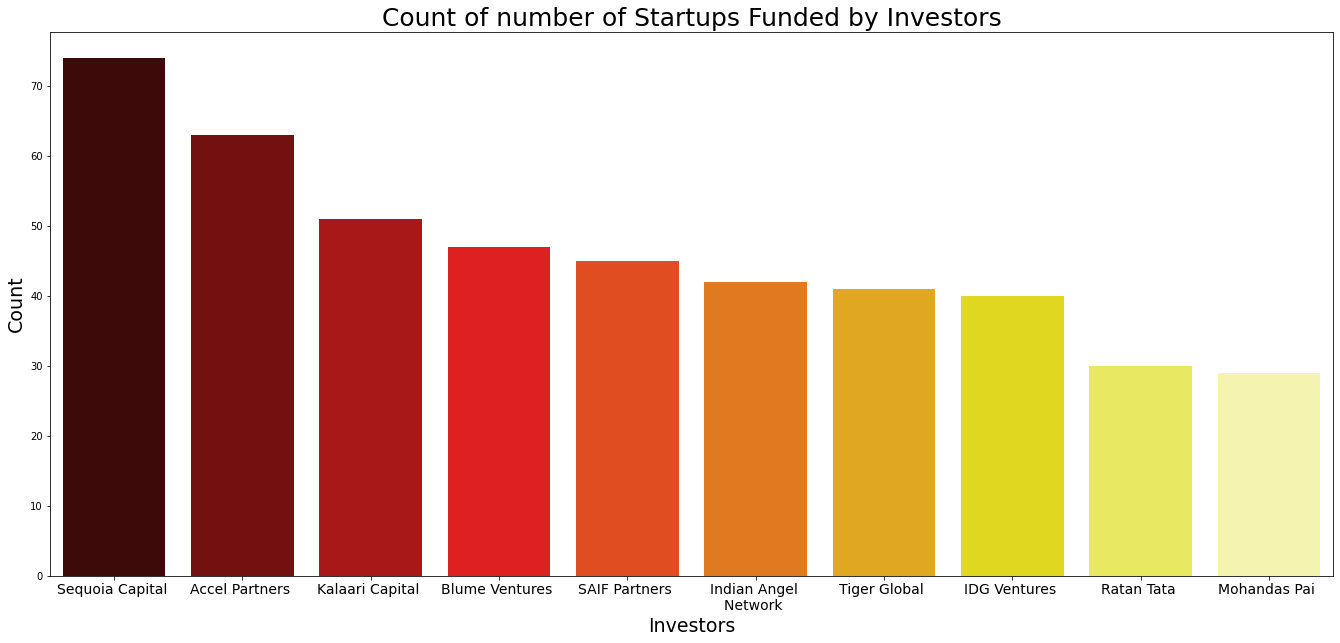

In [72]:
graph_data=pd.Series(values,index=index).sort_values(ascending=False).head(10)
graph_data=ticks_display_cleaner(graph_data)
plt.figure(figsize=(23,10))
plt.xlabel('Investors',fontsize=19)
plt.ylabel('Count',fontsize=19)
plt.title('Count of number of Startups Funded by Investors',fontsize=25)
plt.xticks(fontsize=14)
sns.barplot(graph_data.index,graph_data.values,palette='hot')
plt.savefig('Investors.png',dpi=300)

In [73]:
def startup_finder(investor):
    rows=[]
    for i,v in zip(data['InvestorsName'].index,data['InvestorsName'].values):
        if re.search(investor,v):
            rows.append(i)
    return data.iloc[rows,:]

# **Q7. Which are the most common Investment types?**

In [74]:
data['InvestmentType'].value_counts()

Seed Funding      1272
Private Equity    1066
SeedFunding         30
PrivateEquity        1
Debt Funding         1
Crowd Funding        1
Crowd funding        1
Name: InvestmentType, dtype: int64

Joining duplicate values with different spellings.

In [75]:
data['InvestmentType'].replace('SeedFunding','Seed Funding',inplace=True)
data['InvestmentType'].replace('PrivateEquity','Private Equity',inplace=True)

In [76]:
data['InvestmentType'].value_counts()

Seed Funding      1302
Private Equity    1067
Debt Funding         1
Crowd Funding        1
Crowd funding        1
Name: InvestmentType, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


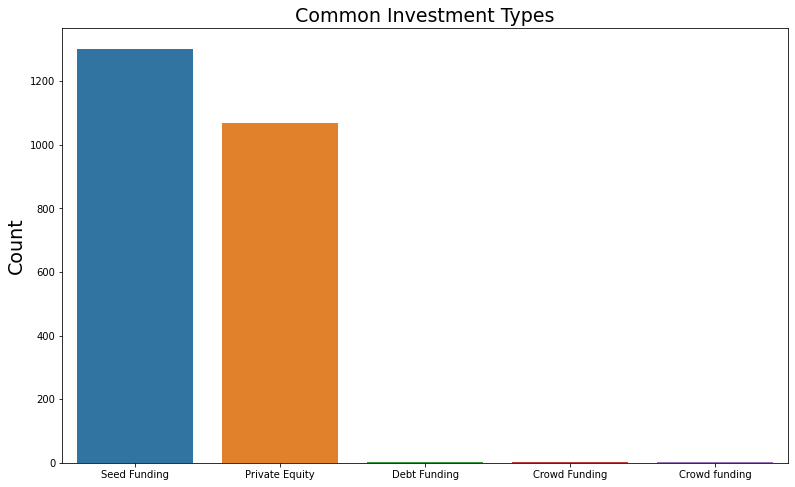

In [77]:
graph_data=data['InvestmentType'].value_counts()
plt.figure(figsize=(13,8))
plt.ylabel('Count',fontsize=19)
plt.title('Common Investment Types',fontsize=19)
sns.barplot(graph_data.index,graph_data.values)
plt.savefig('CommonInvestmentTypes.png',dpi=300)

# **Conclusion**
So, this was all our analysis, we got to know about the industries favored by investors, common investment types, and many more interesting observations about the Indian Startup Ecosystem. We also got to know that the year 2015 and 2016 were the booming years for Indian startups, with the most number of startups funded, and gradually started declining in 2017. A factor that could contribute to this sharp decline would be the announcement of Demonetization by the Indian Government in November 2016.